In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor
%matplotlib inline

In [2]:
args = {
    'noise':0.01,
    'train size':0.7,
    'spec scale':10**12,
    'scaler':RobustScaler()
    }

param_grid = {
    'module__num_hidden' : [15],
    'optimizer' : [torch.optim.Rprop],
    'optimizer__lr' : [0.01],
    'max_epochs' : [512]
}

# Data Prep

In [3]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [4]:
df = pd.read_excel('wide_range.xlsx')

In [5]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [6]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [7]:
# scale for training
scaler = RobustScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [8]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [9]:
# add noise
X_noisy = add_noise(X, args['noise'])

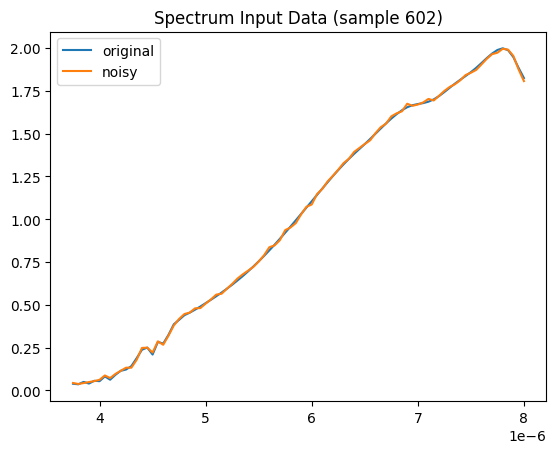

In [10]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [11]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [13]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train.values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test.values, dtype=torch.float32)

    layer['y'] = torch.tensor(y[layer['col']].values, dtype=torch.float32).reshape(-1,1)

In [14]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)

In [15]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        self.num_hidden = num_hidden
        self.criterion = nn.L1Loss()

        hidden_sizes = [input_size]
        step = input_size / (self.num_hidden+1)

        for i in range(self.num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(self.num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x
    


In [16]:
input_size = len(X.columns)
output_size = 1

In [18]:
for layer in layers:
    print("{} gridsearch".format(layer['col']))
    net = NeuralNetRegressor(
        module=FeedForward,
        module__input_size=input_size, 
        module__output_size=output_size,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    gs = GridSearchCV(net, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

    gs.fit(X_tensor, layer['y'])

    best_model = gs.best_estimator_
    best_params = gs.best_params_

    layer['model'] = best_model
    
    print(best_params)
    print('\n')

layer 1 gridsearch
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    91520.5154    26187.4060  0.1787
      2    18874.4865    15143.6304  0.1307
      3    11480.9109     8178.9526  0.1145
      4     4269.3313     1119.5976  0.1110
      5      503.3872      354.4240  0.1166
      6      393.6799      343.2124  0.1150
      7      387.1743      339.4437  0.1298
      8      382.4704      333.7490  0.1208
      9      375.4568      326.9315  0.1121
     10      365.9558      316.4270  0.1179
     11      351.8863      304.5319  0.1120
     12      341.5070      298.7727  0.1121
     13      336.8031      295.6693  0.1137
     14      334.0078      293.8516  0.1129
     15      332.0860      292.4152  0.1178
     16      330.3653      290.8999  0.1207
     17      328.9093      289.7160  0.1129
     18      327.4423      288.2397  0.1366
     19      325.5014      286.1862  0.1152
     20      322.9932      283.6479  0.1071
     21      

In [ ]:
test_losses = []
test_criterion = nn.L1Loss()

for layer in layers:
    features = layer['X_test']
    target = layer['y_test']
    net = layer['model']

    with torch.no_grad():
        pred = net.predict(features)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

TypeError: 'NeuralNetRegressor' object is not callable

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [ ]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [ ]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

In [ ]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)